# Titanic - Age Imputation Algorithm

In [5]:
import os
os.chdir('C:\Users\Lundi\Documents\Programming\Python\Kaggle\Titanic - 2015')

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

titanic_data = pd.read_csv('Data/training_data_v4.csv')
titanic_data = titanic_data.drop(['Unnamed: 0'], axis=1)
titanic_data.head(1)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Is_male,Embarked Q,Embarked S
0,1,0,3,22,1,0,7.25,1,0,1


## Create training set

Our training set will be everyone who already has an age. However, I will remove this age at the beginning. This way, at the end of the imputation process, I can check to see how close the method got.

First, let's filter all rows that don't have an age:

In [8]:
titanic_data_with_age = titanic_data.dropna()
titanic_data_with_age.count()

PassengerId    714
Survived       714
Pclass         714
Age            714
SibSp          714
Parch          714
Fare           714
Is_male        714
Embarked Q     714
Embarked S     714
dtype: int64

#### Seprating design matrix data and age

In [39]:
X = titanic_data_with_age.drop(['Age','PassengerId'], axis=1).reset_index().drop(['index'], axis=1)
y = titanic_data_with_age['Age'].reset_index().drop(['index'], axis=1)

## Insert start age based on linear regression

In order to start the imputaion process, I need a guess for each age. This can be the average of all ages or a linear regression predicted value. I will try to guess an age based on linear regression using the other titanic data:

In [40]:
import sklearn.linear_model as skl_lm
import sklearn.cross_validation as skl_cv
lr_reg = skl_lm.LinearRegression()

skl_cv.cross_val_score(lr_reg, X, y, cv=10, scoring='mean_absolute_error')

array([ -9.46228855, -10.17631779,  -9.14971233,  -9.6694869 ,
        -9.86406396,  -9.84742882, -10.80339726, -10.0702096 ,
       -10.3321003 , -10.35976173])

This shows the linear regression mean error is ~10 years off on average. Let's see the mean error if I used the average age as a start value:

In [53]:
np.sqrt(squared_error_age.sum()) / len(squared_error_age)

Age    1.706411
dtype: float64

In [55]:
kfold = skl_cv.KFold(X.shape[0], n_folds=10)

for train_indexes, test_indexes in kfold:
    train_mean_age = y.ix[train_indexes,:].mean()
    squared_error_age = (y.ix[test_indexes,:] - train_mean_age) ** 2
    rmse_age = np.sqrt(squared_error_age.sum() / len(squared_error_age))
    print rmse_age

Age    14.859839
dtype: float64
Age    15.474003
dtype: float64
Age    13.857501
dtype: float64
Age    13.525595
dtype: float64
Age    12.829935
dtype: float64
Age    15.972775
dtype: float64
Age    15.654678
dtype: float64
Age    14.492105
dtype: float64
Age    14.29756
dtype: float64
Age    14.378473
dtype: float64


These root mean squared errors are much higher than the errors found in the linear regression. So let's use the linear regression to calculate start ages for everyone:

In [59]:
y_start = pd.DataFrame(skl_cv.cross_val_predict(lr_reg, X, y, cv=10), columns=['Age'])
y_start.head(2)

,Age
0,25.256911
1,32.420796


Adding this to X:

In [67]:
X['Start_Age'] = y_start['Age']
X.head(2)

,Survived,Pclass,SibSp,Parch,Fare,Is_male,Embarked Q,Embarked S,Start_Age
0,0,3,1,0,7.2500,1,0,1,25.256911
1,1,1,1,0,71.2833,0,0,0,32.420796


## Perform PCA and get new ages after multiple iters

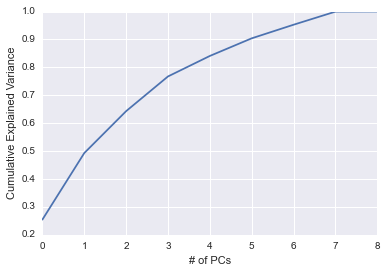

In [85]:
import sklearn.decomposition as skl_decomp
import sklearn.preprocessing as skl_pre
pca = skl_decomp.PCA(n_components=X.shape[1])

X_scaled = skl_pre.scale(X)
pca.fit(X_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
ax = plt.gca()
ax.set_xlabel('# of PCs')
ax.set_ylabel('Cumulative Explained Variance')

This shows that the data requires quite a few PCs to reconstruct the original data. Let's look to see what sort of contribution each PC has on Age:

In [86]:
pd.DataFrame(pca.components_, columns=X.columns).T

,0,1,2,3,4,5,6,7,8
Survived,0.315140,-0.363047,0.068505,-0.509236,0.231545,-0.006674,0.464601,-0.385715,0.294249
Pclass,-0.598346,-0.003873,-0.134022,-0.202624,-0.005051,0.284789,0.130895,0.361900,0.594738
SibSp,-0.208661,-0.445205,0.041915,0.435086,0.380759,-0.458904,-0.276662,-0.164366,0.328737
Parch,-0.076178,-0.454895,0.135897,0.306852,-0.694164,0.309003,0.076843,-0.295345,0.064510
Fare,0.431472,-0.241631,0.065835,0.408951,0.143512,0.136638,0.377270,0.631865,0.054944
Is_male,-0.193807,0.430719,-0.031386,0.478965,0.268427,0.197299,0.509752,-0.418917,0.014455
Embarked Q,-0.039953,-0.056405,-0.743626,0.026364,-0.293979,-0.483172,0.339296,0.040871,-0.069830
Embarked S,-0.250934,0.128376,0.631015,-0.075117,-0.238471,-0.541985,0.371861,0.157446,-0.055162
Start_Age,0.452805,0.446631,0.025315,0.114799,-0.289100,-0.167258,-0.170246,-0.069300,0.660552


This shows that start age contibutes quite largely to the first two PCs. It also contributes heavily to the fifth and ninth PCs. These are too high to use though. Let's use two PCs in our reconstruction:

In [141]:
pca_2 = skl_decomp.PCA(n_components=2)
scaler = skl_pre.StandardScaler()

age_comparison = pd.DataFrame({'Start_Age': X['Start_Age'], 
                              'Actual_Age': y['Age']})
X_iter = X.copy()
for iter_num in xrange(100):
    scaler.fit(X_iter)
    X_scaled = scaler.transform(X_iter)
    pca_2.fit(X_scaled)

    reconstructed_X = pca_2.inverse_transform(pca_2.transform(X_scaled))
    new_age = pd.DataFrame(scaler.inverse_transform(reconstructed_X), columns=X.columns)['Start_Age']

    age_comparison['Iter' + str(iter_num)] = new_age
    X_iter['Start_Age'] = new_age
age_comparison.head(2)

,Actual_Age,Start_Age,Iter0,Iter1,Iter2,Iter3,Iter4,Iter5,Iter6,Iter7,...,Iter90,Iter91,Iter92,Iter93,Iter94,Iter95,Iter96,Iter97,Iter98,Iter99
0,22,25.256911,25.957265,26.342265,26.519972,26.585865,26.597493,26.585532,26.565205,26.543563,...,26.406324,26.406321,26.406319,26.406316,26.406314,26.406312,26.406310,26.406308,26.406307,26.406305
1,38,32.420796,33.677904,34.363576,34.777784,35.044291,35.223584,35.349167,35.440787,35.510386,...,35.952837,35.952853,35.952868,35.952881,35.952893,35.952905,35.952915,35.952924,35.952933,35.952940


#### Plotting average difference from actual age as iterations go on:

In [129]:
difference_from_actual.ix[0:10,:]

,Start_Age,Iter0,Iter1,Iter2,Iter3,Iter4,Iter5,Iter6,Iter7,Iter8,...,Iter90,Iter91,Iter92,Iter93,Iter94,Iter95,Iter96,Iter97,Iter98,Iter99
0,3.256911,3.957265,4.342265,4.519972,4.585865,4.597493,4.585532,4.565205,4.543563,4.523556,...,4.406324,4.406321,4.406319,4.406316,4.406314,4.406312,4.406310,4.406308,4.406307,4.406305
1,-5.579204,-4.322096,-3.636424,-3.222216,-2.955709,-2.776416,-2.650833,-2.559213,-2.489614,-2.434722,...,-2.047163,-2.047147,-2.047132,-2.047119,-2.047107,-2.047095,-2.047085,-2.047076,-2.047067,-2.047060
2,-3.578982,-0.734414,1.037719,2.140522,2.842579,3.300518,3.605000,3.809872,3.948285,4.041413,...,4.062437,4.062421,4.062407,4.062394,4.062383,4.062372,4.062362,4.062353,4.062345,4.062337
3,-0.924590,-1.906281,-2.348377,-2.528638,-2.594982,-2.618675,-2.631021,-2.644153,-2.661645,-2.683603,...,-3.177937,-3.177967,-3.177995,-3.178020,-3.178043,-3.178064,-3.178083,-3.178100,-3.178116,-3.178131
4,-5.667550,-4.986604,-4.699854,-4.581872,-4.539139,-4.530026,-4.535458,-4.546662,-4.559657,-4.572695,...,-4.717296,-4.717304,-4.717310,-4.717317,-4.717322,-4.717327,-4.717332,-4.717336,-4.717340,-4.717344
5,-8.915192,-12.120425,-14.160561,-15.389307,-16.137983,-16.611460,-16.925355,-17.143742,-17.302567,-17.422571,...,-18.105051,-18.105078,-18.105102,-18.105124,-18.105144,-18.105162,-18.105179,-18.105194,-18.105208,-18.105221
6,13.961981,13.459347,13.406942,13.350957,13.254832,13.143588,13.037525,12.946117,12.871813,12.813611,...,12.687140,12.687146,12.687151,12.687156,12.687161,12.687165,12.687169,12.687173,12.687176,12.687179
7,-6.580002,-6.736910,-6.416725,-6.070577,-5.783227,-5.561216,-5.395328,-5.274430,-5.188495,-5.129173,...,-5.174129,-5.174143,-5.174155,-5.174166,-5.174177,-5.174186,-5.174195,-5.174203,-5.174210,-5.174217
8,10.744851,13.583347,15.303850,16.356237,17.019826,17.454295,17.750523,17.960888,18.116151,18.234799,...,18.934587,18.934613,18.934638,18.934660,18.934680,18.934698,18.934715,18.934730,18.934744,18.934757
9,13.262300,14.774871,15.972380,16.771105,17.288401,17.625160,17.847040,17.994545,18.092809,18.157823,...,18.155354,18.155344,18.155334,18.155326,18.155318,18.155310,18.155304,18.155298,18.155292,18.155287


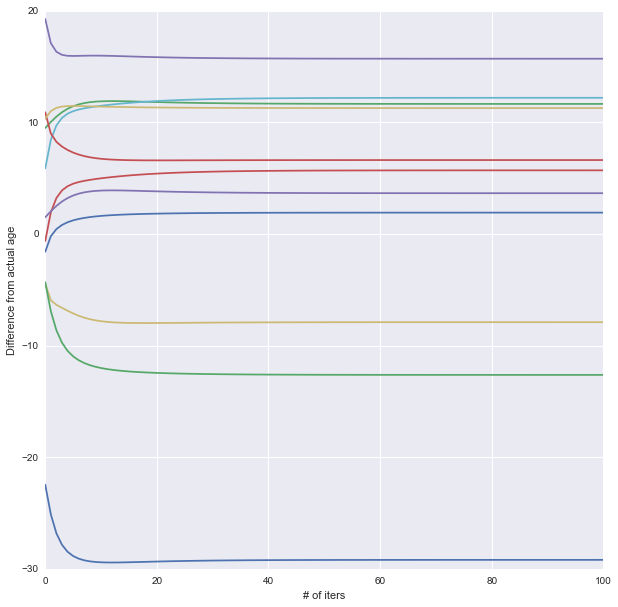

In [140]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10,10
difference_from_actual = age_comparison.drop(['Actual_Age'], axis=1).sub(age_comparison['Actual_Age'], axis=0)
plt.plot(difference_from_actual.ix[40:50,:].T);
ax = plt.gca()
ax.set_xlabel('# of iters')
ax.set_ylabel('Difference from actual age')

In [149]:
average_difference_start = np.abs(difference_from_actual['Start_Age']).mean()
average_difference_final_iter = np.abs(difference_from_actual['Iter99']).mean()
print 'Start Diff: ' , average_difference_start
print 'End Diff: ' , average_difference_final_iter

Start Diff:  9.97146537728
End Diff:  10.6975194502


This shows that many ages get worse after imputation. 

Let's redo it with more PCs:

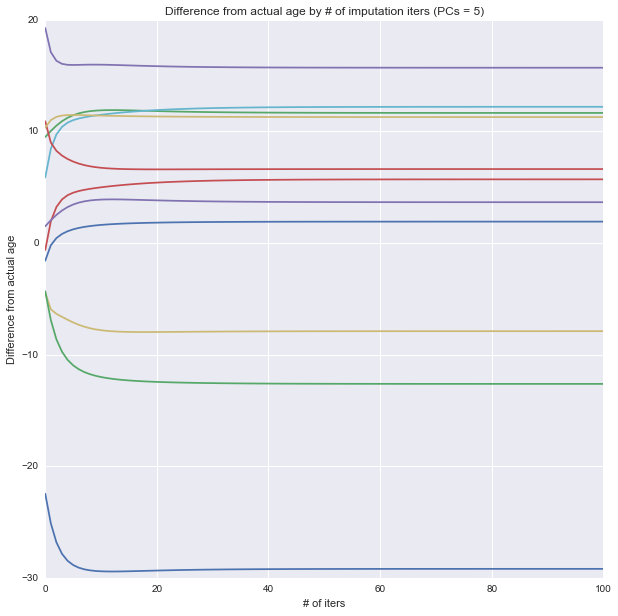

In [142]:
pca_5 = skl_decomp.PCA(n_components=5)
scaler = skl_pre.StandardScaler()

age_comparison_pc_5 = pd.DataFrame({'Start_Age': X['Start_Age'], 
                              'Actual_Age': y['Age']})
X_iter = X.copy()
for iter_num in xrange(100):
    scaler.fit(X_iter)
    X_scaled = scaler.transform(X_iter)
    pca_2.fit(X_scaled)

    reconstructed_X = pca_2.inverse_transform(pca_2.transform(X_scaled))
    new_age = pd.DataFrame(scaler.inverse_transform(reconstructed_X), columns=X.columns)['Start_Age']

    age_comparison_pc_5['Iter' + str(iter_num)] = new_age
    X_iter['Start_Age'] = new_age
age_comparison_pc_5.head(2)

difference_from_actual_pc_5 = age_comparison_pc_5.drop(['Actual_Age'], axis=1).sub(age_comparison['Actual_Age'], axis=0)
plt.plot(difference_from_actual_pc_5.ix[40:50,:].T);
ax = plt.gca()
ax.set_xlabel('# of iters')
ax.set_ylabel('Difference from actual age')
ax.set_title('Difference from actual age by # of imputation iters (PCs = 5)')

In [150]:
average_difference_start = np.abs(difference_from_actual_pc_5['Start_Age']).mean()
average_difference_final_iter = np.abs(difference_from_actual_pc_5['Iter99']).mean()
print 'Start Diff: ' , average_difference_start
print 'End Diff: ' , average_difference_final_iter

Start Diff:  9.97146537728
End Diff:  10.6975194502


## Conclusions
Age imputation doesn't improve the prediction of age over linear regression prediction